#Importing the Required Library.
Pandas, Numpy, Tensorflow, Sklearn, Keras, Tokenizer and etc.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split


import keras
from keras.preprocessing import text,sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Loading the dataset.
Dataset taken from Kaggle

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/clickbait_data.csv')

# Split dataset into training and testing sets using train and test split.

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Tokenize the text data for computation.
To convert text in numerical sequence.

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data['headline'])

# Convert text data to sequences

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_data['headline'])
test_sequences = tokenizer.texts_to_sequences(test_data['headline'])

# Pad the sequences to a fixed length 
maximum length is 500

In [ ]:
max_length = 500
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

# Load pre-trained word embeddings.
We use GloVe's 6 Billion tokens with 100 dimensions. It is faster and efficient for our problem statement. 

In [ ]:
embedding_dim = 100
embeddings_index = {}
with open('/content/drive/MyDrive/glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create embedding matrix using GloVe Word Embeddings.

In [ ]:
num_words = min(5000, len(tokenizer.word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Intialize the parameters for LSTM model.

In [ ]:
vocab_size = 5000
maxlen = 500
embedding_size = 32

#Define the Model Structure

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(LSTM(32, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 100)          500000    
                                                                 
 lstm_1 (LSTM)               (None, 500, 32)           17024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 517,057
Trainable params: 17,057
Non-trainable params: 500,000
___________________________________________

Callbacks use for prevent overfitting.

In [ ]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=3,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='weights.h5',
        monitor='val_accuracy', 
        mode='max', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]


# Compile the model

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model

In [ ]:
history = model.fit(train_padded_sequences, train_data['clickbait'], epochs=35, batch_size=512, validation_split=0.2, callbacks=callbacks)

Epoch 1/35
39/40 [============================>.] - ETA: 0s - loss: 0.5043 - accuracy: 0.7941
Epoch 1: val_accuracy improved from -inf to 0.91562, saving model to weights.h5
40/40 [==============================] - 4s 47ms/step - loss: 0.4992 - accuracy: 0.7975 - val_loss: 0.2955 - val_accuracy: 0.9156
Epoch 2/35
39/40 [============================>.] - ETA: 0s - loss: 0.2211 - accuracy: 0.9327
Epoch 2: val_accuracy improved from 0.91562 to 0.94219, saving model to weights.h5
40/40 [==============================] - 1s 32ms/step - loss: 0.2192 - accuracy: 0.9334 - val_loss: 0.1740 - val_accuracy: 0.9422
Epoch 3/35
39/40 [============================>.] - ETA: 0s - loss: 0.1507 - accuracy: 0.9514
Epoch 3: val_accuracy improved from 0.94219 to 0.94824, saving model to weights.h5
40/40 [==============================] - 1s 32ms/step - loss: 0.1497 - accuracy: 0.9518 - val_loss: 0.1430 - val_accuracy: 0.9482
Epoch 4/35
39/40 [============================>.] - ETA: 0s - loss: 0.1286 - accur

# Evaluate the model on the test set

In [ ]:
test_loss, test_accuracy = model.evaluate(test_padded_sequences, test_data['clickbait'])
print('Test accuracy:', test_accuracy)

200/200 [==============================] - 2s 9ms/step - loss: 0.0931 - accuracy: 0.9702
Test accuracy: 0.9701562523841858


In [ ]:
test = ["Man breaks into opera at eatery after seeing pizza","How A.I. and DNA Are Unlocking the Mysteries of Global Supply Chains,’ Prigozhin says.","Shahid Kapoor and Kriti Sanon's new film poster leaves internet baffled","Anupam Kher reacts after Anurag Basu makes dosa for him on Metro In Dino sets","A Profit for Medco and a Loss for Tenet"]
token_text = pad_sequences(tokenizer.texts_to_sequences(test), maxlen=max_length)
preds = [round(i[0]) for i in model.predict(token_text)]
for (text, pred) in zip(test, preds):
    label = 'Clickbait' if pred == 1.0 else 'Not Clickbait'
    print("{} - {}".format(text, label))

1/1 [==============================] - 0s 362ms/step
Man breaks into opera at eatery after seeing pizza - Not Clickbait
How A.I. and DNA Are Unlocking the Mysteries of Global Supply Chains,’ Prigozhin says. - Clickbait
Shahid Kapoor and Kriti Sanon's new film poster leaves internet baffled - Not Clickbait
Anupam Kher reacts after Anurag Basu makes dosa for him on Metro In Dino sets - Not Clickbait
A Profit for Medco and a Loss for Tenet - Not Clickbait


#Plotting the Results for evaluting the model accuracy and efficiency.

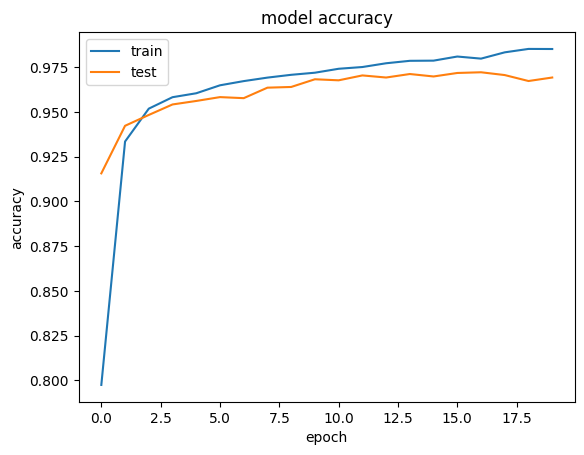

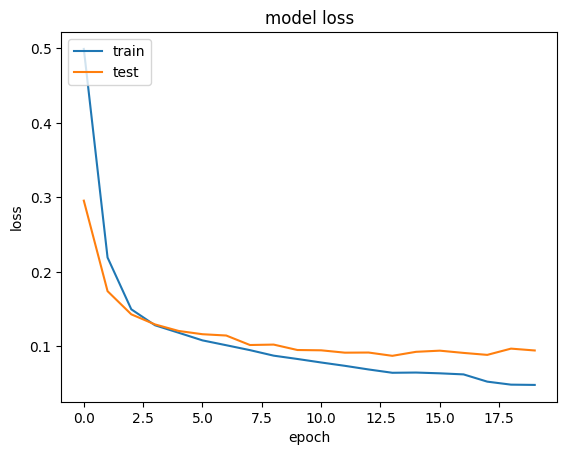

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.load_weights('weights.h5')
from tensorflow.keras.models import save_model
save_model(model,'model8.h5')

In [ ]:
from tensorflow.keras.models import load_model
mod = load_model('model8.h5',compile=False)
mod.load_weights('weights.h5')

In [ ]:
test = ["Why Pope Francis Is the Star of A.I.-Generated Photos","Thailand’s Unemployed Elephants Are Back Home, Huge and Hungry","How A.I. and DNA Are Unlocking the Mysteries of Global Supply Chains,’ Prigozhin says.","French Diplomacy Undercuts U.S. Efforts to Rein China In","Family from Gujarat drowns while attempting illegal crossing over St. Lawrence river on Canada-U.S. border","Why Pope Francis Is the Star of A.I.-Generated Photos"]
token_text = pad_sequences(tokenizer.texts_to_sequences(test), maxlen=max_length)
preds = [round(i[0]) for i in mod.predict(token_text)]
for (text, pred) in zip(test, preds):
    label = 'Clickbait' if pred > 0.5 else 'Not Clickbait'
    print("{} - {}".format(text, label))

1/1 [==============================] - 1s 527ms/step
Why Pope Francis Is the Star of A.I.-Generated Photos - Not Clickbait
Thailand’s Unemployed Elephants Are Back Home, Huge and Hungry - Not Clickbait
How A.I. and DNA Are Unlocking the Mysteries of Global Supply Chains,’ Prigozhin says. - Not Clickbait
French Diplomacy Undercuts U.S. Efforts to Rein China In - Not Clickbait
Family from Gujarat drowns while attempting illegal crossing over St. Lawrence river on Canada-U.S. border - Not Clickbait
Why Pope Francis Is the Star of A.I.-Generated Photos - Not Clickbait


#Confusion Marix

200/200 [==============================] - 1s 7ms/step


<Figure size 640x480 with 0 Axes>

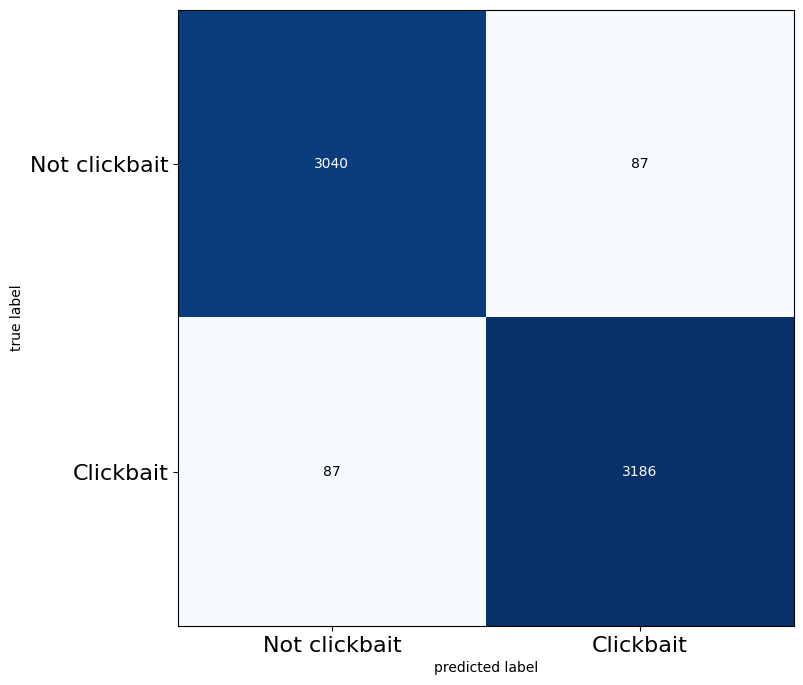

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

preds = [round(i[0]) for i in mod.predict(test_padded_sequences)]
cm = confusion_matrix(test_data['clickbait'], preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Not clickbait', 'Clickbait'], fontsize=16)
plt.yticks(range(2), ['Not clickbait', 'Clickbait'], fontsize=16)
plt.show()

#Classification Report

In [ ]:
from sklearn.metrics import classification_report

y_true = test_data['clickbait']  # True labels of the test set
y_pred_probs = mod.predict(test_padded_sequences)  # Predicted probabilities of the test set
y_pred = (y_pred_probs > 0.5).astype(int)

#classification report
print(classification_report(y_true, y_pred))

200/200 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3127
           1       0.97      0.97      0.97      3273

    accuracy                           0.97      6400
   macro avg       0.97      0.97      0.97      6400
weighted avg       0.97      0.97      0.97      6400



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pickle

# Create a tokenizer and fit it to your data

# Save the tokenizer as a pickle file
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)